In [1]:
from sklearn.datasets import load_iris, load_breast_cancer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the IRIS dataset
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target

# Load the Breast Cancer dataset
breast_cancer = load_breast_cancer()
breast_cancer_df = pd.DataFrame(data=breast_cancer.data, columns=breast_cancer.feature_names)
breast_cancer_df['target'] = breast_cancer.target


In [2]:
# Creating a Dic to Store the Data for Each Class ===> {class1: Data frame of Class 1}
df = {}
df["setosa"]=iris_df.groupby(['target']).get_group(0)
df["versicolor"]=iris_df.groupby(['target']).get_group(1)
df["virginica"]=iris_df.groupby(['target']).get_group(2)

array([<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
       <Axes: ylabel='Density'>, <Axes: ylabel='Density'>], dtype=object)

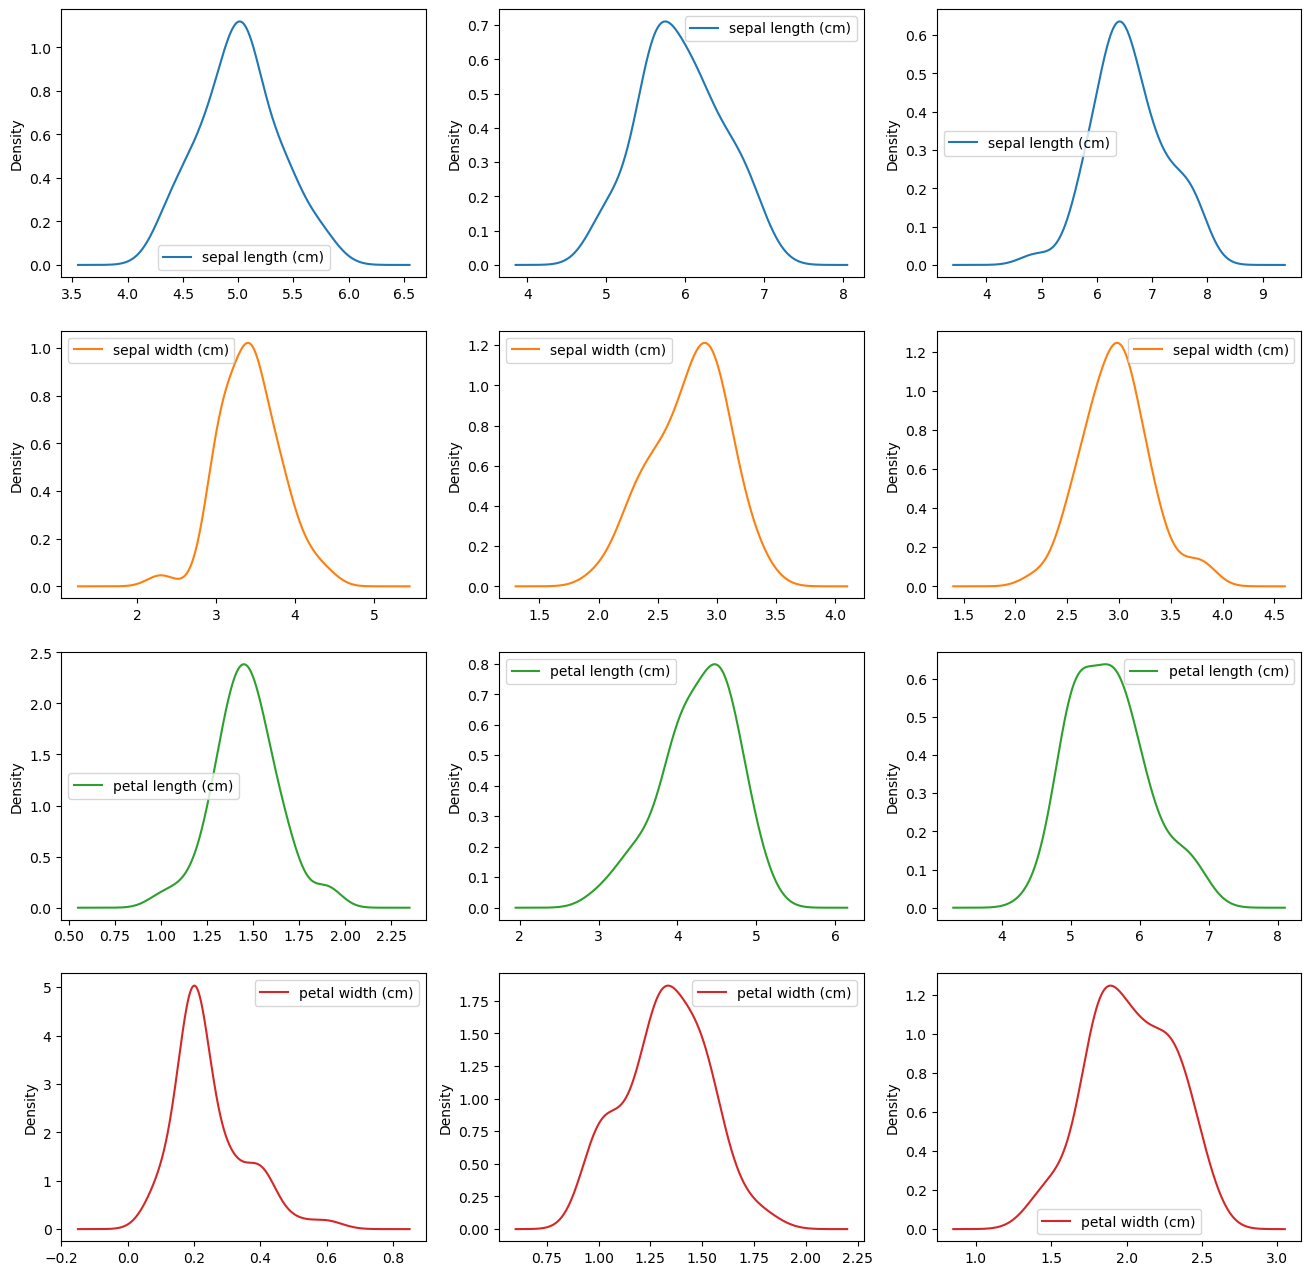

In [321]:
#Graph for each feature of each class
figure, axes = plt.subplots(nrows=4 , ncols=3,figsize = (16,16))
df["setosa"].drop(['target'],axis=1).plot(ax = axes[:,0],subplots=True,kind='kde')
df["versicolor"].drop(['target'],axis=1).plot(ax = axes[:,1],subplots=True,kind='kde')
df['virginica'].drop(['target'],axis=1).plot(ax = axes[:,2],subplots=True,kind='kde')
#     Setosa - Versicolor - virginica

In [3]:
#Parzen Window
def Vec_distance(vec1,vec2):#calculate the Distance between Two vectors 
    Distance = 0
    for i in range(len(vec1)):
        Distance = Distance + (vec1[i] - vec2[i])**2
    Distance = Distance**0.5
    return Distance

 # Kernel with a Hard treshold | if the point is within the HyperCube around the input--> returns 1, otherewise 0
def Parzen_kernel(Distance,h):
    
    if Distance/h < 0.5:
        return 1
    return 0

def Parzen_Guassian_kernel(Distance,h): # smooth estimation based on a guassian distribution
    Pdf = (1/(((2*np.pi)**0.5)*h))*(np.exp(-(Distance**2)/(2*(h**2))))
    return Pdf

# h--> BandWidth, dataframe ---> a Dic containing a data frame for each class
def Parzen_window(input,dataframe,h):
    classP = []
    N = 0 #Number of samples
    #counting the samples in each class
    for df in dataframe:
        N += len(dataframe[df])
    
    for df in dataframe:
        k = 0 # number of points within the hypercube
        # calculating PDF
        for x in dataframe[df].drop(['target'],axis=1).values :
            Distance = Vec_distance(x,input)
            k += Parzen_Guassian_kernel(Distance,h) # number of points within the hypercube
        PDI = k / (N*(h**len(x)))
        classP.append(PDI)
    
    return classP.index(max(classP))



# K-Nearest Neighbors

In [6]:
#KNN

#Finding the distance between input vector and all the samples
def Matrix_Vec_distance(Mat1,Mat2):  

    Distance = ((Mat1 - Mat2)**2)
    Distance = np.sum(Distance,axis=1)
    Distance = Distance**0.5

    return Distance # n*1 vector containing distance of the input and all the samples

#finds the k nearest samples to the input
def K_Smallest_Values(Mat,K): 
    
    smallest = np.argsort(Mat[:,0])[:K] 

    return Mat[smallest]

def KNN(input,Dataframe,K):

    target = Dataframe['target']
    i_matrix = np.array([input,]*len(Dataframe.drop(['target'],axis=1))) #creates a matrix with the same value for each row as input * N ---> number of Data points
    D_matrix = Matrix_Vec_distance(i_matrix,Dataframe.drop(['target'],axis=1).values) # returns a matrix of distances to each data sample of (N * 1)
    D_matrix = np.column_stack((D_matrix,target))#creates a N *2 matrix of Distances and their target
    KValues =K_Smallest_Values(D_matrix,K)#finds the k nearest samples to the input
    #Convert into a dataframe
    KValues = pd.DataFrame(KValues,columns=['Distance','Target']) 
    prediction = KValues.Target.mode().values # returns the class with the highest number of points in Kvalue

    return prediction 

### Testing Parzen Window 

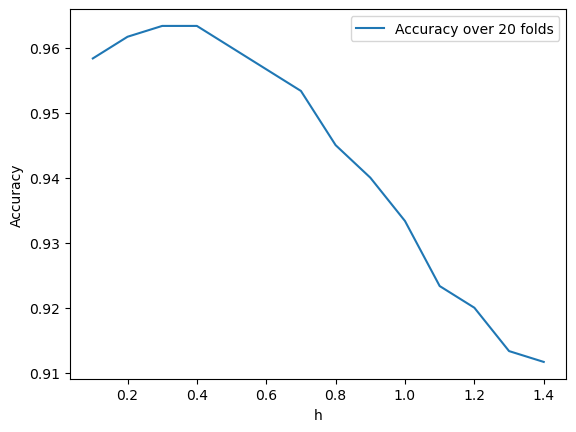

In [4]:
#Cross Validation for iris Dataset
from sklearn.model_selection import train_test_split
folds=20
result = []
#cross validation of k folds
for k in range(folds):

    iris_train, iris_test = train_test_split(iris_df, test_size=0.2,random_state=k)
    df_i= {}
    df_i["setosa"]=iris_train.groupby(['target']).get_group(0)
    df_i["versicolor"]=iris_train.groupby(['target']).get_group(1)
    df_i["virginica"]=iris_train.groupby(['target']).get_group(2)
    list=[]

    for h in range(1,15,1):
        h= h/10
        r = 0
        for i in iris_test.values:
            target = i[-1]
            pred = Parzen_window(i[:-1],df_i,h)
            if target == pred:
                r += 1
        acc = r/len(iris_test.values)
        list.append([acc,h])

    if result == []:
        result = list
    else:
        for i in range(len(list)):
            result[i][0] = result[i][0] + list[i][0]
for i in range(len(list)):
    result[i][0] = result[i][0] / folds
result = pd.DataFrame(result,columns=['Accuracy','h'])

plt.plot(result['h'],result['Accuracy'], label=f'Accuracy over {folds} folds')
plt.ylabel('Accuracy')
plt.xlabel('h')
plt.legend()


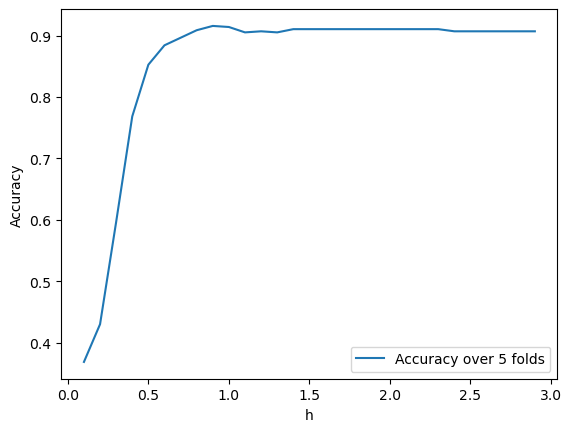

In [4]:
#Cross Validation for breast_cancer Dataset
from sklearn.model_selection import train_test_split
folds=5
result = []
#cross validation of k folds
for k in range(folds):

    breast_cancer_train, breast_cancer_test = train_test_split(breast_cancer_df, test_size=0.2,random_state=k)
    df_b= {}
    df_b["malignan"]=breast_cancer_train.groupby(['target']).get_group(0)
    df_b["benign"]=breast_cancer_train.groupby(['target']).get_group(1)
    list=[]
    
    for h in range(1,30,1):
        h= h/10
        r = 0
        for i in breast_cancer_test.values:
            target = i[-1]
            prob = Parzen_window(i[:-1],df_b,h)
            if target == prob:
                r += 1
        acc = r/len(breast_cancer_test.values)
        list.append([acc,h])

    if result == []:
        result = list
    else:
        for i in range(len(list)):
            result[i][0] = result[i][0] + list[i][0]
for i in range(len(list)):
    result[i][0] = result[i][0] / folds
result = pd.DataFrame(result,columns=['Accuracy','h'])

plt.plot(result['h'],result['Accuracy'], label=f'Accuracy over {folds} folds')
plt.ylabel('Accuracy')
plt.xlabel('h')
plt.legend()



### Testing KNN

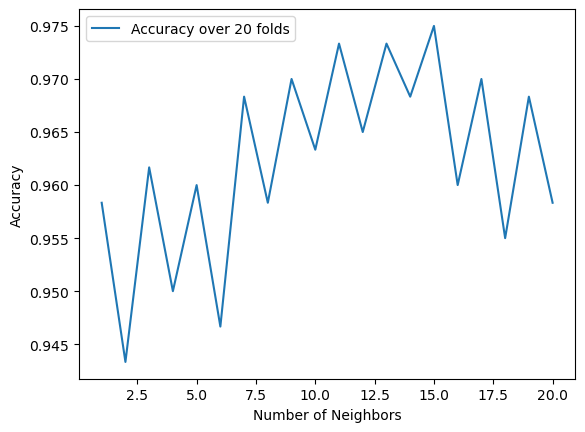

In [7]:

from sklearn.model_selection import train_test_split
folds=20
result = []
#cross validation of k folds
for k in range(folds):

    iris_train, iris_test = train_test_split(iris_df, test_size=0.2,random_state=k)
    list= []

    for n in range(20):
        n +=1
        r= 0
        for i in iris_test.values:
            t = i[-1]
            i = i[0:-1]
            pred = KNN(i,iris_train,n)
            #Checking for the same number of points for 2 classes
            if len(pred)==1:
                if pred == t:
                    r +=1
        acc = r/len(iris_test.values)
        list.append([acc,n])

    if result == []:
        result = list
    else:
        for i in range(len(list)):
            result[i][0] = result[i][0] + list[i][0]
            
for i in range(len(list)):
    result[i][0] = result[i][0] / folds
result = pd.DataFrame(result,columns=['Accuracy','k'])

plt.plot(result['k'],result['Accuracy'], label=f'Accuracy over {folds} folds')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.legend()

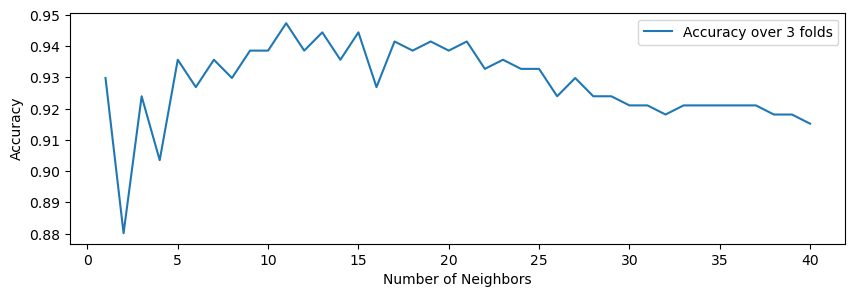

In [8]:

from sklearn.model_selection import train_test_split
folds=3
result = []
#cross validation of k folds
for k in range(folds):

    k = k+5
    breast_cancer_train, breast_cancer_test = train_test_split(breast_cancer_df, test_size=0.2,random_state=k)
    list= []
    
    for n in range(40):
        n +=1
        r= 0 #stores the number of right guesses
        for i in breast_cancer_test.values:
            t = i[-1] #Target Class number
            i = i[0:-1] # feature vector
            pred = KNN(i,breast_cancer_train,n)
            #Checking for the same number of points for 2 classes
            if len(pred)==1:
                if pred == t: #checks if prediction and target class are the same (if model predicted right)
                    r +=1 
        acc = r/len(breast_cancer_test.values) #calculates the precentage of the right prediction compare to all the data
        #storing accuracy for different number of naighbor counted
        list.append([acc,n])

    # list containing avarge of accuracy for differenet number of naighbor 1 through n 
    if result == []:
        result = list
    else:
        for i in range(len(list)):
            result[i][0] = result[i][0] + list[i][0]
            
for i in range(len(list)):
    result[i][0] = result[i][0] / folds
result = pd.DataFrame(result,columns=['Accuracy','k'])

plt.figure(figsize=(10,3))
plt.plot(result['k'],result['Accuracy'], label=f'Accuracy over {folds} folds')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors')
plt.legend()

## Part Two
### Combining KNN and Parzen Window 

In [10]:
#Changing Parzen for this Task
def Vec_distance2(vec1,vec2):#calculate the Distance between Two vectors 

    Distance = (vec1[0] - vec2[0])**2
    Distance = Distance**0.5
    return Distance

def Parzen_window2(input,dataframe,h):# X===> dataframe with a Vector, h--> BandWidth, dataframe ---> a Dic containing a data frame for each class
    
    classP = []
    N = len(dataframe) #Number of samples
    #creating a dic containing each class
    df = {}
    df["setosa"]=dataframe.groupby(['target']).get_group(0)
    df["versicolor"]=dataframe.groupby(['target']).get_group(1)
    df["virginica"]=dataframe.groupby(['target']).get_group(2)
    
    for f in df:
        k = 0 # number of points within the hypercube
        for x in df[f].drop(['target'],axis=1).values :# calculating PDF
            Distance = Vec_distance2(x,input)
            k += Parzen_Guassian_kernel(Distance,h) 
        PDFI = k / (N*(h**len(x)))
        classP.append(PDFI)
    
    return classP.index(max(classP))
        
        

In [15]:
iris_train, iris_test = train_test_split(iris_df, test_size=0.2,random_state=30)
preds = []
k = 13
h =0.3
for s in iris_test.values:
    t = s[-1]
    prediction = np.array([0.0,0.0,0.0])
    #KNN Predictions
    for i in range(4):# adjusting prediction matrix with KNN
        p = KNN(s[i:i+1],iris_train[[iris_df.columns[i],'target']],k)
        if len(p) == 1:
            prediction[int(p[0])] =prediction[int(p[0])] + 0.125
    #Parzen Predictions
    for i in range(4):# adjusting prediction matrix with Parzen Windows
        p = Parzen_window2(s[i:i+1],iris_train[[iris_df.columns[i],'target']],h)
        prediction[p] =prediction[p] + 0.125
    
    preds.append([prediction,t])
r = 0
for i in preds:
    #Cheking to see if predicted class is the same as the actual class for the s(tested point)
    if np.argmax(i[0]) == i[1]:
        r += 1
r/len(iris_test.values)

0.9666666666666667